# Installations

In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.8 MB/s eta 0:00:00


# Components of RAG

#1.Chat Model

There are may AI chat models available:
1. Open AI     (Azure)
2. Google Vertex AI   
3. Claude      (Anthropic, AWS)
4. Cohere
5. Llama       (Grouq, NVIDIA, Fireworks AI, Databricks)
6. Mistral     (Together AI)

In [ ]:
!pip install -qU langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 8.7 MB/s eta 0:00:00


Get api key of groq from https://console.groq.com/keys

In [ ]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

# 2.Embedding Model

Followings are the embedding models available:
1. OpenAI (Azure)
2. Google Vertex AI
3. HuggingFace (sentence transformers)
4. Cohere
5. Mistral AI
6. NVIDIA
7. Voyage AI
8. AWS
9. Ollama
10. Nomic

In [ ]:
!pip install -qU langchain-huggingface

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 3.Vector Store

Following vector stores can be used:
1. In-memory LangChain
2. AstraDB
3. Chroma
4. FAISS (Facebook)
5. Milvus
6. MongoDB
7. PGVector
8. Pinecone
9. Qdrant

In [ ]:
!pip install -qU langchain-pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 8.2 MB/s eta 0:00:00


In [ ]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="pcsk_cMxH1_KMbU8bUVJhx98ZoU2rHHWKPBb3eFCydCsSarY2dGp37ySkubuEAkF9BU2EJJyWP")
index_name = "ragqa"
dimension = 768  # Replace with your model's embedding size
metric = "cosine"  # Can also be "dotproduct" or "euclidean"
# Check existing indexes
existing_indexes = pc.list_indexes()  # Returns metadata for indexes
existing_index_names = {idx["name"] for idx in existing_indexes}

print("Existing Indexes: ", existing_index_names)
# Check if the index exists
if index_name not in existing_index_names:
    # Create a new index if it doesn't exist
    print(f"Index '{index_name}' does not exist. Creating a new one...")
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric=metric,
        spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1",
      ),
      deletion_protection="disabled"
    )
else:
    print(f"Index '{index_name}' already exists.")

index = pc.Index(index_name)

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

Existing Indexes:  {'llama-2-rag-test', 'rag-workshop'}
Index 'ragqa' does not exist. Creating a new one...


# RAG Application Pipeline

# 1.Indexing

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43131


In [ ]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [ ]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['89f8ba4f-6c12-4ba2-b489-1faefbf64a22', '4692ec57-d037-4f32-b7cb-e79b372f6f89', '4aa133dc-39c4-44d1-b0df-3d39cb3bbd72']


# 2.Reterival

Prompt Template

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


Custom Template

In [ ]:
from langchain.prompts import PromptTemplate

# Define your custom prompt template
custom_template = """
You are an intelligent assistant that provides concise, accurate, and helpful answers.
Use the following context to answer the question.

Context:
{context}

Question:
{question}

Answer:
"""

# Initialize the PromptTemplate
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=custom_template,
)

# Provide the context and question
example_messages = prompt.format(
    context="Large Language Models (LLMs) are powerful tools for natural language processing tasks.",
    question="What are LLMs used for?",
)

# Print the result
print(example_messages)


The **similarity_search** method accepts raw text and automatically embeds it using the Embedding object provided when you initialized the PineconeVectorStore. You can also provide a k value to determine the number of LangChain Document objects to return. The default value is k=4

In [ ]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [ ]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


# 3.Generation

In [ ]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

# LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent. The best way to do this is with LangSmith https://smith.langchain.com

In [ ]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter API Key: ")

Enter API Key: ··········


# LangGraph

In [ ]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.6 MB/s eta 0:00:00


For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer


**Nodes** (application steps)
Let's start with a simple sequence of two steps: retrieval and generation.

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

In [ ]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

**Control flow**
Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

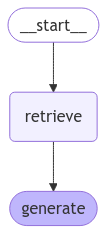

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Application

**Usage**
Let's test our application! LangGraph supports multiple invocation modes, including sync, async, and streaming.

**Invoke:**

In [ ]:
userQuery = "What is Self reflection?" # @param {"type":"string","placeholder":"Enter query here..."}
result = graph.invoke({"question": userQuery})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='37fb6be1-a01a-4fd3-b1fd-f82550d81b02', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 5222.0}, page_content='Fig. 3. Illustration of the Reflexion framework. (Image source: Shinn & Labash, 2023)\nThe heuristic function determines when the trajectory is inefficient or contains hallucination and should be stopped. Inefficient planning refers to trajectories that take too long without success. Hallucination is defined as encountering a sequence of consecutive identical actions that lead to the same observation in the environment.\nSelf-reflection is created by showing two-shot examples to LLM and each example is a pair of (failed trajectory, ideal reflection for guiding future changes in the plan). Then reflections are added into the agent’s working memory, up to three, to be used as context for querying LLM.'), Document(id='9cdfdc61-f94c-4fcd-9bb1-16ae9ce59299', metadata={'source': 'https://lilianweng.github.io/posts/2023

# Deep Understanding

**Application steps:**

In [ ]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='7ae3de0e-73ba-4a1f-9491-6597a4689594', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192.0}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(id='c0b6e732-140d-4397-8c1c-c72f3b44489a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 19373.0}, page_

**Stream tokens:**

In [ ]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| Decom|position| is| the| process| of| breaking| down| a| problem| into| multiple| thought| steps| and| generating| multiple| thoughts| per| step|,| creating| a| tree| structure|.| This| can| be| done| using| Large| Language| Models| (|LL|Ms|)| with| simple| prompting|,| task|-specific| instructions|,| or| human| inputs|.| The| goal| is| to| explore| multiple| reasoning| possibilities| at| each| step|.||